# Federated Learning Simulation with Flower (Kaggle)

This notebook shows how to simulate federated learning using Flower (FLwr)
.
We’ll use 3 clients, each training on a different subset of MNIST digits:

Client 1 → Digits 0–3

Client 2 → Digits 4–6

Client 3 → Digits 7–9

Then, the server aggregates their updates using FedAvg to build a global model.

In [2]:
# Install Flower and TensorFlow
!pip install flwr tensorflow -q

In [4]:
import flwr as fl
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np


In [5]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
(x_train, y_train)

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],

In [8]:
# Normalize to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

In [9]:
print("Training samples:", x_train.shape)
print("Test samples:", x_test.shape)

Training samples: (60000, 28, 28)
Test samples: (10000, 28, 28)


In [10]:
#We use a simple Multi-Layer Perceptron (MLP)
def create_model():
    """Build and compile a simple MLP for MNIST."""
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),    # Flatten 28x28 images
        layers.Dense(128, activation="relu"),    # Hidden layer
        layers.Dense(10, activation="softmax"),  # Output layer for 10 digits
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [12]:
#Partition Data for Clients:Each client only sees part of the dataset, simulating Non-IID data.
def get_client_data(client_id):
    """Return different partitions of MNIST for each client."""
    if client_id == 0:
        mask = y_train < 4               # Digits 0–3
    elif client_id == 1:
        mask = (y_train >= 4) & (y_train < 7)  # Digits 4–6
    else:
        mask = y_train >= 7              # Digits 7–9
    return x_train[mask], y_train[mask]


In [25]:
#Define Flower Client
class MnistClient(fl.client.NumPyClient):
    def __init__(self, client_id):
        self.model = create_model()
        self.client_id = client_id
        self.x, self.y = get_client_data(client_id)

    def get_parameters(self, config):
        # Return model parameters
        return self.model.get_weights()

    def fit(self, parameters, config):
        # Train on local data
        self.model.set_weights(parameters)
        self.model.fit(self.x, self.y, epochs=1, batch_size=32, verbose=0)
        return self.model.get_weights(), len(self.x), {}

    def evaluate(self, parameters, config):
        
       self.model.set_weights(parameters)
       loss, acc = self.model.evaluate(x_test, y_test, verbose=0)
       print(f"[Client {self.client_id}] Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")
       return loss, len(x_test), {"accuracy": acc}


In [26]:
def aggregate_accuracy(metrics):
    # metrics is a list of (num_examples, metrics_dict)
    total_examples = sum(num_examples for num_examples, _ in metrics)
    weighted_acc = sum(num_examples * m["accuracy"] for num_examples, m in metrics)
    return {"accuracy": weighted_acc / total_examples}


In [40]:
from flwr.server.strategy import FedAvg

class SaveModelStrategy(FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.final_parameters = None

    def aggregate_fit(self, server_round, results, failures):
        aggregated_parameters, metrics = super().aggregate_fit(server_round, results, failures)
        if aggregated_parameters is not None:
            self.final_parameters = aggregated_parameters
        return aggregated_parameters, metrics


In [42]:
strategy = SaveModelStrategy(
    evaluate_metrics_aggregation_fn=aggregate_accuracy
)

history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
)


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
2025-09-15 08:46:25,200	INFO worker.py:1917 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:172.19.2.2': 1.0, 'node:__internal_head__': 1.0, 'CPU': 4.0, 'object_store_memory': 9159811891.0, 'memory': 21372894413.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_c

(ClientAppActor pid=5745) [Client 2] Test Loss: 1.3745, Test Accuracy: 0.5119


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=5746) 
(ClientAppActor pid=5746)         
(ClientAppActor pid=5746) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=5746)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=5746)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=5746) /usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` ob

(ClientAppActor pid=5746) [Client 0] Test Loss: 1.1008, Test Accuracy: 0.5615 [repeated 3x across cluster]


(ClientAppActor pid=5744) 
(ClientAppActor pid=5744)         
(ClientAppActor pid=5744) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=5744)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=5744)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=5744) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]
(ClientAppActor pid=5745) 
(ClientAppActor pid=5745)         
(ClientAppActor pid=5746) 
(ClientAppActor pid=5746)         
INFO :      aggregat

(ClientAppActor pid=5744) [Client 0] Test Loss: 1.0668, Test Accuracy: 0.5820 [repeated 3x across cluster]
(ClientAppActor pid=5745) [Client 1] Test Loss: 1.0668, Test Accuracy: 0.5820


In [46]:
print(history.metrics_distributed)

{'accuracy': [(1, 0.511900007724762), (2, 0.5615000128746033), (3, 0.5820000171661377)]}


In [47]:
from flwr.common import parameters_to_ndarrays

final_weights = parameters_to_ndarrays(strategy.final_parameters)

# Load into a fresh Keras model
global_model = create_model()
global_model.set_weights(final_weights)


In [48]:
loss, acc = global_model.evaluate(x_test, y_test, verbose=0)
print(f"Federated Global Model Test Accuracy: {acc:.4f}")


Federated Global Model Test Accuracy: 0.5820


{'accuracy': [(1, 0.511900007724762), (2, 0.5615000128746033), (3, 0.5820000171661377)]}


In [35]:
# Build a fresh model
global_model = create_model()

# Get the final aggregated parameters from Flower
final_parameters = history.metrics_distributed["accuracy"]

final_parameters


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[(1, 0.5424000024795532), (2, 0.589900016784668), (3, 0.6678000092506409)]

In [51]:
central_model = create_model()
central_model.fit(x_train, y_train, epochs=3, batch_size=32, verbose=1)
loss, acc = central_model.evaluate(x_test, y_test, verbose=0)
print(f"Centralized Model Test Accuracy: {acc:.4f}")


Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8753 - loss: 0.4374
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9647 - loss: 0.1209
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9764 - loss: 0.0783
Centralized Model Test Accuracy: 0.9729


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


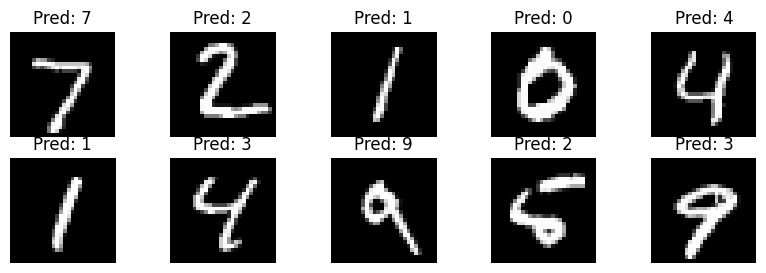

In [52]:
import matplotlib.pyplot as plt

# Predict on first 10 test samples
predictions = np.argmax(global_model.predict(x_test[:10]), axis=1)

plt.figure(figsize=(10,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[i], cmap="gray")
    plt.title(f"Pred: {predictions[i]}")
    plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


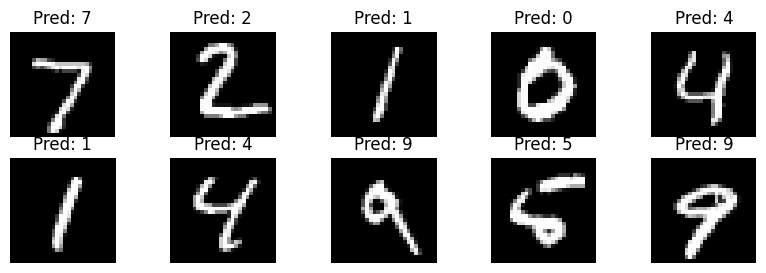

In [55]:
import matplotlib.pyplot as plt

# Predict on first 10 test samples
predictions = np.argmax(central_model.predict(x_test[:10]), axis=1)

plt.figure(figsize=(10,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[i], cmap="gray")
    plt.title(f"Pred: {predictions[i]}")
    plt.axis("off")
plt.show()
